# Week 3: Regular expressions

In [1]:
from tock import *

# Tuesday

<div class="alert alert-info">
    <p><b>Read</b> Section 1.3, but you can save Lemma 1.60 and its proof for next time.</p>
    <p><b>Watch</b> <a href="https://notredame.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=1313eb6c-5928-40f0-8b39-ac0100f99057">W3E1: Regular Expressions</a>.</p>
</div>

## Regular expressions

Regular expressions were invented by Stephen Kleene (pronounced clay-knee) back in the 1950s as a characterization of the languages recognized by the earliest neural networks. But they became widely used through various Unix tools, like `grep`, which is where you have likely encountered them.

![Regex Golf](http://imgs.xkcd.com/comics/regex_golf.png)

Our regular expressions are defined inductively. Let $\Sigma$ be an alphabet. The set of *regular expressions* over $\Sigma$ is the smallest set such that:

- If $a \in \Sigma$, then $a$ is a regular expression.
- $\varepsilon$ is a regular expression.
- $\emptyset$ is a regular expression.
- If $\alpha$ and $\beta$ are regular expressions, then $\alpha \cup \beta$ is a regular expression.
- If $\alpha$ and $\beta$ are regular expressions, then $\alpha \beta$ (or $\alpha \circ \beta$) is a regular expression.
- If $\alpha$ is a regular expression, then $\alpha^\ast$ is a regular expression.

The order of operations is star, then concatenation, then union (so, for example, $a\cup bc^\ast = a \cup (b(c^\ast))$). Use parentheses to change the order of operations, just as in arithmetic expressions.

The $\cup$ operator is the same as the Unix `|` operator. Unix regular expressions use a dot (`.`) to match any symbol; we use $\Sigma$ for this purpose.

Another difference is that Unix regular expressions usually match anywhere in a string, whereas our regular expressions usually must match the entire string. When using `grep`, use the `-Ex` flags to approximate our regular expressions (`-E` to get the union operator, `-x` to match the whole line).

In [2]:
%%file movies.txt
the phantom menace
attack of the clones
revenge of the sith
a new hope
the empire strikes back
return of the jedi
the force awakens
rogue one
the last jedi
solo
the rise of skywalker
the motion picture
the wrath of khan
the search for spock
the voyage home
the final frontier
the undiscovered country
generations
first contact
insurrection
nemesis
into darkness
beyond

Overwriting movies.txt


In [3]:
!grep -Ex '.*(m | (t|n)|b).*' movies.txt

the phantom menace
attack of the clones
revenge of the sith
a new hope
the empire strikes back
return of the jedi
beyond


Almost right.

**Exercise.** Can you fix the regular expression so that it also accepts `the force awakens`, `rogue one`, `the last jedi`, `solo`, and `the rise of skywalker`, but not `beyond`?

## Converting regular expressions to NFAs

<p class="alert alert-info"><b>Watch</b> <a href="https://notredame.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=9fc0b75d-c122-498b-b804-ac0100f995d5">W3E2: Regular Expressions to NFAs</a>.</p>

Regular expressions are the third "model of computation" of this course, and they, too, are equivalent to both DFAs and NFAs. The proof involves algorithms to convert between regular expressions and NFAs. Today we're converting regular expressions to NFAs, which is not as difficult as the subset construction from last time.

The algorithm in the book is a slight variation on the algorithm from a paper by Ken Thompson, one of the co-developers of Unix, [for the QED editor](https://swtch.com/~rsc/regexp/regexp1.html), from which are descended `sed`, `grep`, and `vi`. (But many modern regular expression engines actually do not use this algorithm; they use one that is asymptotically much slower!)

The conversion is a recursive procedure that walks through the structure of the regular expression. We'll write it as a proof that uses structural induction.

Theorem: Any regular expression $\alpha$ can be converted into an equivalent NFA.

Proof: By induction on the structure of $\alpha$.

If $\alpha = a$, we can convert it to the NFA:

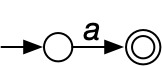

If $\alpha = \varepsilon$, we can convert it to the NFA:

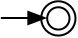

If $\alpha = \emptyset$, we can convert it to the NFA:

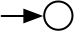

Now we need three inductive steps, which go like this:

If $\alpha = \beta \cup \gamma$, then by the inductive hypothesis, we can convert $\beta$ to an equivalent NFA $B$ and $\gamma$ to an equivalent NFA $C$. Then we can construct an NFA that recognizes $\mathcal{L}(B) \cup \mathcal{L}(C)$. (See below for how to do this.)

Similarly if $\alpha = \beta \gamma$ or $\alpha = \beta^\ast$.

So to complete this proof, we need to show how to perform the union, concatenation, and Kleene star operations on NFAs. These are much easier than the intersection construction was. 

### Union

First we prove that regular languages are closed under union. Given two NFAs $B$ and $C$, we can picture each of them using this cartoon:

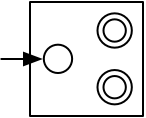

The cartoon only shows the start state and accept states and omits all other states. Also, in reality there might be fewer than two or more than two accept states.

Then this is an NFA that recognizes $\mathcal{L}(B) \cup \mathcal{L}(C)$:

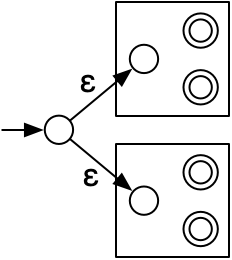

**Exercise**. Write the construction of this NFA more formally.

**Question**. What would be wrong with simply merging the two start states? Why are the $\varepsilon$-transitions needed?

### Concatenation

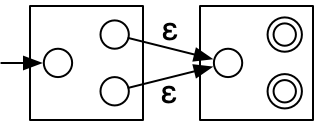

### Kleene star

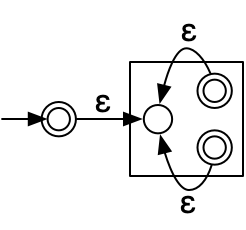

**Question.** Why do we need to create a new start state?

### Putting it together

Here's a step by step visualization of the example from the book. You can try different regular expressions to see how they get converted. (Note that in Tock, unlike in Unix tools, symbols in regular expressions are separated by spaces.)

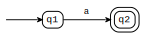

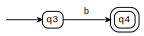

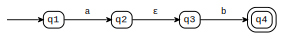

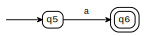

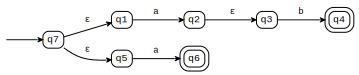

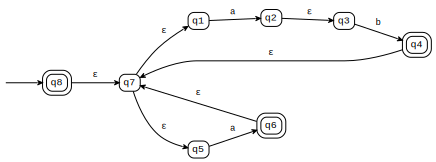

In [4]:
m = from_regexp('(a b|a)*', display_steps=True)

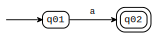

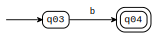

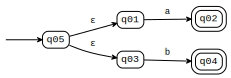

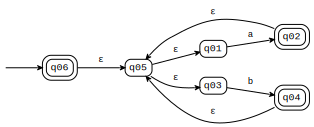

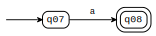

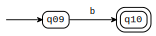

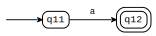

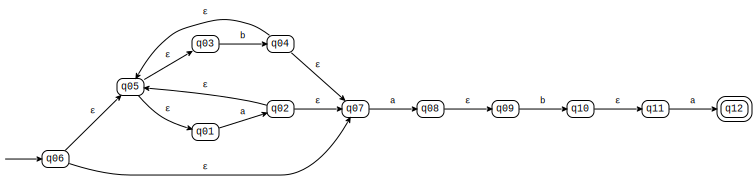

In [5]:
m = from_regexp('(a|b)* a b a', display_steps=True)

**Question.** If a regular expression has $n$ symbols, how big will the resulting NFA be?

For a very cool "real-time" visualization of (a slightly different version of) this construction, see [Debuggex](https://www.debuggex.com).

# Thursday

<div class="alert alert-info"><p><b>Read</b> (or reread) Lemma 1.60 and its proof.</p>
    <p><b>Watch</b> <a href="https://notredame.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=403486b2-0fa1-4927-8500-ac01012a0743">W3E3: NFAs to Regular Expressions</a>.</p>
</div>

## NFAs to regular expressions

Today we're completing the proof from last time by converting NFAs to regular expressions. The algorithm for this is known as the _state elimination_ algorithm, because it eliminates the states of the NFA one by one. 

To make this construction simpler, the new concept of a generalized NFA (GNFA) is introduced. In this course, GNFAs are a "throwaway" formalism; they exist just to make this proof possible. But elsewhere they might be useful in their own right. A GNFA is a NFA whose transitions can be labeled with regular expressions instead of symbols. A GNFA can follow a transition if the next $k \geq 0$ symbols match the regular expression; when it follows the transition, it consumes those $k$ symbols.

Here's the big picture of the algorithm:

1. Preprocess the NFA so it has a single start state with no incoming edges and a single accept state with no outgoing edges.
2. For each non-start, non-accept state $q$:
    1. Eliminate $q$ (see below).
    2. Merge any parallel transitions.
3. There is only one transition, labeled with a regular expression equivalent to the original NFA.

First, the algorithm changes the NFA so it has a single start state with no incoming edges and a single accept state with no outgoing edges.

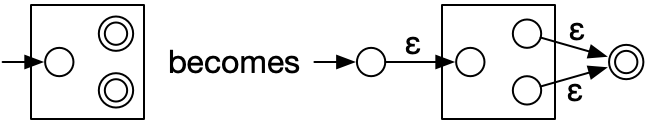

This makes the final step of the algorithm simpler. 

(The book also creates a lot of transitions labeled $\emptyset$; these are not shown in the figures below, and they're not shown in the book, either. In fact, as far as I'm concerned, you can pretend they don't exist.)

Second, the algorithm then eliminates the (non-start, non-accept) states one by one. The general procedure is to eliminate state $q$ is, for all incoming transitions and all outgoing transitions of $q$, do:

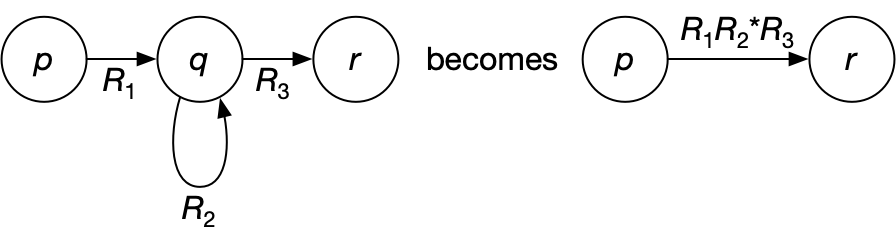

But this is definitely something that will be clearer by example.

The order of elimination is arbitrary, although some orders may lead to more compact regular expressions than others. Tock eliminates states in reverse alphabetical order, for no particularly good reason. 

After eliminating each state, we also merge any parallel transitions (transitions that have the same "from" and "to" states):

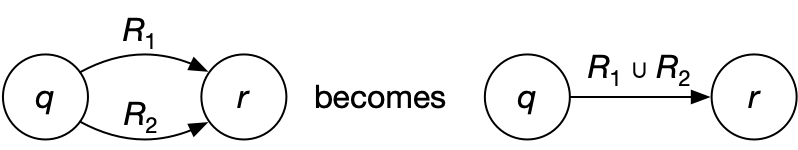

Finally, when there is just one transition left, its label is the final answer. (If you're not using $\emptyset$ transitions, then there is a special case: if there are no transitions left, then the answer is $\emptyset$.) 

<div class="alert alert-info">
    <p><b>Watch</b> <a href="https://notredame.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=ad7cf26a-ac40-480f-8597-ac01012a0e19">W3E4: NFAs to Regular Expressions (Examples)</a>.</p>
</div>

Let's start with a simpler example than the one in the book, a NFA whose state diagram is *acyclic*.

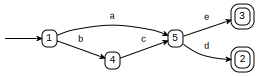

In [6]:
m = read_csv('acyclic.csv')
m

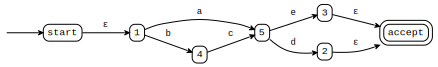

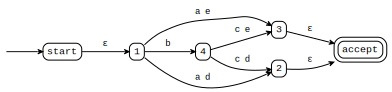

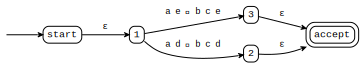

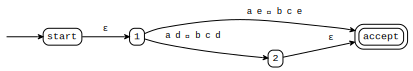

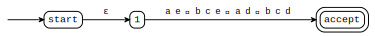

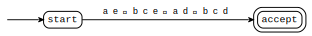

In [7]:
to_regexp(m, display_steps=True)

The first state to be eliminated is 5. This state has two incoming transitions (a and c) and two outgoing transitions (d and e). In order for the new GNFA to be equivalent to the old one, we have to create four transitions to replace the deleted ones: ad, ae, cd, and ce.

The next state to be eliminated is 4. This creates two new transitions (bce and bde), but since there are already transitions parallel to these (ae and ad), the new transitions are merged with the old ones.

Eliminating state 2 is not very interesting; neither is eliminating state 3, except note again that parallel transitions are unioned.

Now here's an example with a cycle in it; these give rise to Kleene stars in the resulting expression.

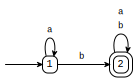

In [8]:
m66 = read_csv('sipser-1-66.csv')
m66

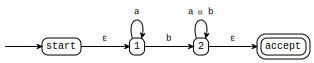

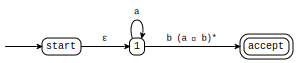

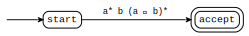

In [9]:
to_regexp(m66, display_steps=True)

Eliminating state 2 looks similar to before, but the self-loops turn into subexpressions inside Kleene stars.

One more example from the book:

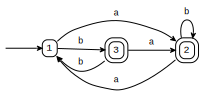

In [10]:
m68 = read_csv('sipser-1-68.csv')
m68

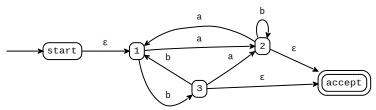

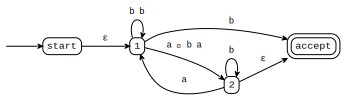

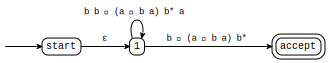

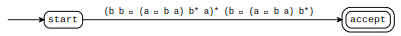

In [13]:
to_regexp(m68, display_steps=True)

(The answer is different from the book's because the elimination order was different.)

## Implementing automata and regular expressions (optional)

<p class="alert alert-info"><b>Watch</b> <a href="https://notredame.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=2688e344-99de-47bc-a771-ac02013cd848">W3E5: Implementing Regular Expressions</a>.</p>

To match a regular expression $\alpha$ and a string $w$, we first convert $\alpha$ to a NFA $N$, using the above algorithm.

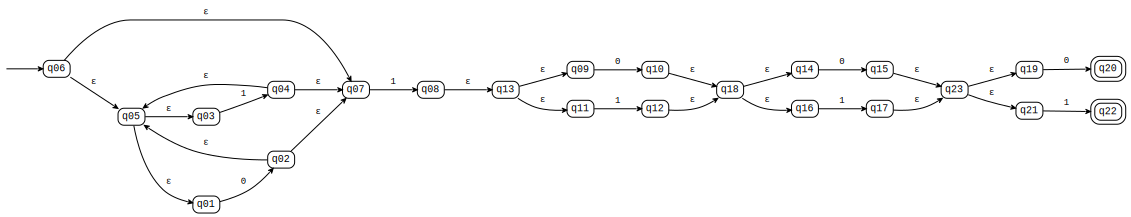

In [109]:
alpha = '(0|1)* 1 (0|1) (0|1) (0|1)'
w = '0 1 1 0'
n = from_regexp(alpha)
n

Then we have a few choices.

- We could convert $N$ to a DFA using the algorithm we studied last week. But this creates $2^{|Q|}$ states, which could be expensive.

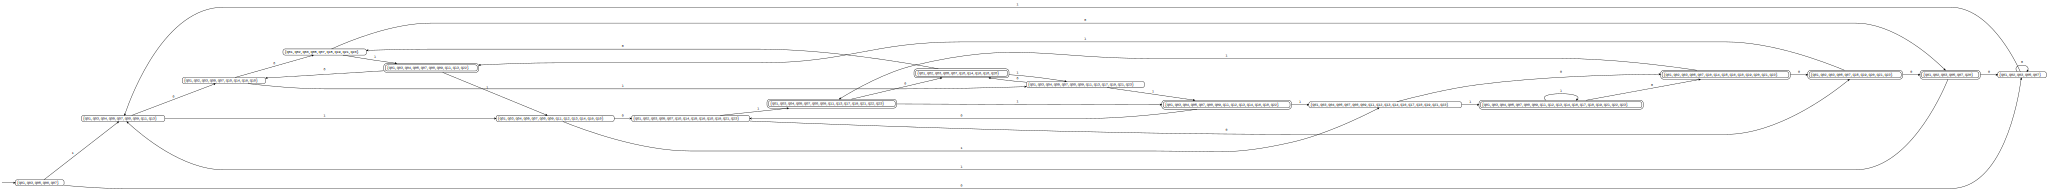

In [108]:
determinize(n)

- We could do the conversion to a DFA on-the-fly, computing just the states of the DFA that we actually need to process $w$.
    - $\bar{q} \leftarrow E(\{s\})$
    - for $i \leftarrow 1, \ldots, |w|$
        - $\bar{q} \leftarrow E(\{\delta(q, w_i) \mid q \in \bar{q}\})$
    - return $\bar{q} \cap F \neq \emptyset$
    
- We could construct the run graph of $N$ on $w$ and search for a path in it from the start state to the accept state, using breadth-first search. This is what Tock does.

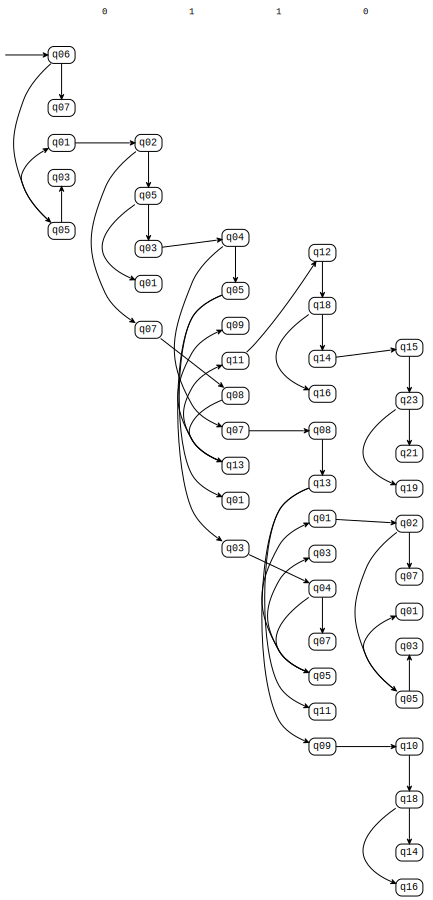

In [110]:
g = run(n, w)
g

In [20]:
g.shortest_path()

q8,[a] b a
q7,[a] b a
q1,[a] b a
q2,[b] a
q3,[b] a
q4,a
q7,a
q5,a
q6,ε


Let's analyze the running time of this algorithm in terms of $|\alpha|$ and $|w|$.

- Converting to a NFA takes time $O(|\alpha|)$ and results in a NFA with $O(|\alpha|)$ states. This can be shown by induction on the structure of $\alpha$.
- The run graph has $O(|\alpha| |w|)$ nodes and $O(|\alpha|^2 |w|)$ edges, and it takes $O(|\alpha|^2 |w|)$ time to construct.
- A breadth-first search takes time $O(|\alpha| |w| + |\alpha|^2 |w|) = O(|\alpha|^2 |w|)$.

So the total running time is $O(|\alpha|^2 |w|)$.

Let's test it out on a [specially crafted regular expression](https://swtch.com/~rsc/regexp/regexp1.html):

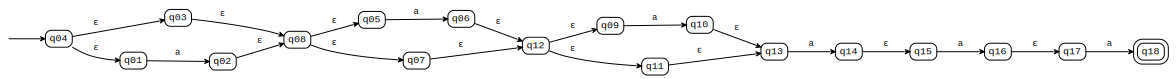

In [64]:
def evil_tock_regexp(i):
    return ('(a|&)'*i + ' a'*i)

from_regexp(evil_tock_regexp(3))

We plot the running time of the matcher for various lengths of regular expressions and compare it against the best-fit cubic curve:

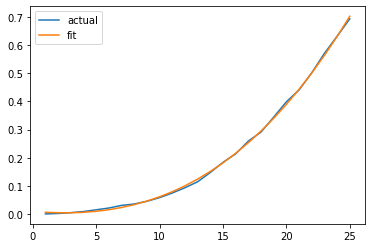

In [86]:
%matplotlib inline
import timeit
import matplotlib.pyplot as plt
import numpy as np

def match(n, w):
    g = run(n, w)
    g.shortest_path()

lengths = list(range(1, 26))
tock_times = []
for i in lengths:
    tock_times.append(timeit.timeit(lambda: match(from_regexp(evil_tock_regexp(i)), ['a']*i), number=1))

coeffs = np.polyfit(lengths, tock_times, deg=3)
fit = np.polyval(coeffs, lengths)
    
plt.plot(lengths, tock_times, label='actual')
plt.plot(lengths, fit, label='fit')
plt.legend()
plt.show()

Okay, how about Python's regular expression matcher?

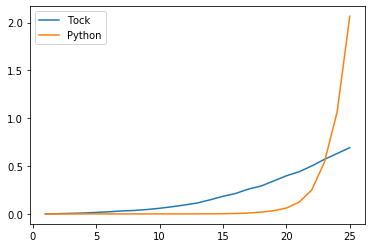

In [87]:
import re

def evil_regexp(i):
    return ('(?:a|)'*i + 'a'*i)

py_times = []
for i in lengths:
    py_times.append(timeit.timeit(lambda: re.fullmatch(evil_regexp(i), 'a'*i), number=1))

plt.plot(lengths, tock_times, label='Tock')
plt.plot(lengths, py_times, label='Python')
plt.legend()
plt.show()

What happened? Python's regular expression matcher seems to be much worse than cubic -- in fact, it's exponential. If we had increased the length much beyond 25, the above code would take a very, very long time to complete. Instead of compiling to an NFA, it seems to use backtracking. 

The moral of the story: theory sometimes matters in practice! Google's [RE2](https://github.com/google/re2) engine does not have this problem.